In [1]:
import warnings

warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

In [2]:
# 读取数据
train = pd.read_csv(r".\Data\train_data.csv")
test = pd.read_csv(r".\Data\test_data.csv")

# 标准化数据
scaler = MinMaxScaler(feature_range=(0, 1))
features = ["temp", "atemp", "hum", "windspeed", "season", "weekday", "hr", "holiday", "weathersit", "workingday","casual","cnt","registered","season"]
train = train[features]
test = test[features]
train.dropna(inplace=True)
features = features[:-1]
train[features] = scaler.fit_transform(train[features])
test[features] = scaler.transform(test[features])

cnt_scaler = MinMaxScaler()
train["cnt"] = cnt_scaler.fit_transform(train[["cnt"]])
test["cnt"] = cnt_scaler.transform(test[["cnt"]])

In [3]:
# 准备数据
def prepare_data(X, y, past_steps=96, forecast_steps=240):
    Xs, Ys = [], []
    for i in tqdm(range(len(X) - past_steps - forecast_steps + 1)):
        # 输入包含过去 96 小时的数据
        Xs.append(X.iloc[i:i + past_steps].to_numpy())
        # 输出为未来 240 小时的目标值
        Ys.append(y.iloc[i + past_steps:i + past_steps + forecast_steps].to_numpy())
    return np.array(Xs), np.array(Ys)


past_steps = 96    # 利用过去 
forecast_steps = 240  # 预测未来 

X_train, y_train = prepare_data(train, train.cnt, past_steps=past_steps, forecast_steps=forecast_steps)
X_test, y_test = prepare_data(test, test.cnt, past_steps=past_steps, forecast_steps=forecast_steps)

# 转换为 PyTorch 张量
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)



print("X_train : {}\nX_test : {}\ny_train : {}\ny_test: {}".format(X_train.shape,X_test.shape,y_train.shape,y_test.shape))


100%|██████████| 1825/1825 [00:00<00:00, 14730.03it/s]

X_train : torch.Size([14881, 96, 14])
X_test : torch.Size([1825, 96, 14])
y_train : torch.Size([14881, 240])
y_test: torch.Size([1825, 240])


In [4]:
    
import torch
import torch.nn as nn

class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, num_heads=4, forecast_steps=240):
        super(LSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim * 2, num_heads=num_heads, batch_first=True)
        
        # 添加归一化层（LayerNorm）
        self.lstm_norm = nn.LayerNorm(hidden_dim * 2)
        self.attn_norm = nn.LayerNorm(hidden_dim * 2)
        
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 4, forecast_steps)  # 拼接后维度翻倍

    def forward(self, x):
        # LSTM 输出
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_dim * 2)
        lstm_out = self.lstm_norm(lstm_out)  # 对 LSTM 输出进行归一化
        
        # 多头注意力模块
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)  # attn_out: (batch_size, seq_len, hidden_dim * 2)
        attn_out = self.attn_norm(attn_out)  # 对注意力输出进行归一化

        # 取 LSTM 的最后时间步和注意力输出的最后时间步
        lstm_last_step = lstm_out[:, -1, :]  # (batch_size, hidden_dim * 2)
        attn_last_step = attn_out[:, -1, :]  # (batch_size, hidden_dim * 2)

        # 拼接最后时间步的 LSTM 和注意力输出
        combined = torch.cat([lstm_last_step, attn_last_step], dim=-1)  # (batch_size, hidden_dim * 4)

        # Dropout 和全连接层预测未来 240 小时
        combined = self.dropout(combined)
        output = self.fc(combined)  # (batch_size, forecast_steps)

        return output




input_dim = X_train.shape[2]  # 输入特征的维度
hidden_dim = 128             # LSTM 的隐藏单元数
output_dim = 1               # 单步输出
num_layers = 1               # LSTM 层数
num_heads = 16                # 注意力头数
model = LSTMWithAttention(input_dim, hidden_dim, output_dim, num_layers, num_heads, forecast_steps)

In [5]:
model = torch.load("240-2.pth")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # 移动到设备
print(f"Using device: {device}")
X_test = X_test.to(device)
y_test = y_test.to(device)
forecast_steps = 240
# 切换模型到评估模式
model.eval()
#测试5次
epoch = 5
batch_size = 32

Using device: cuda


In [6]:
mse_list = []
real_mse_list = []
mae_list = []
real_mae_list = []
with torch.no_grad():
    # 使用模型进行预测
    mse, mae = 0, 0
    print(X_test.shape)
    y_pred = model(X_test).cpu().numpy()  # 预测值转为 NumPy 数组
    y_true = y_test.cpu().numpy()  # 真实值转为 NumPy 数组
    y_true_inv = cnt_scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, forecast_steps))
    y_pred_inv = cnt_scaler.inverse_transform(y_pred.reshape(-1, forecast_steps))
    # print(y_true_inv, y_pred_inv)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    real_mse = mean_squared_error(y_true_inv, y_pred_inv)
    real_mae = mean_absolute_error(y_true_inv, y_pred_inv)
    print(f"Test : MSE = {mse:.4f}, MAE = {mae:.4f}, real_mse = {real_mse:.4f}, real_mae = {real_mae:.4f}")
    mse_list.append(mse)
    real_mse_list.append(real_mse)
    mae_list.append(mae)
    real_mae_list.append(real_mae)
average_mse = np.mean(mse_list)
average_mae = np.mean(mae_list)
real_average_mse = np.mean(real_mse_list)
real_average_mae = np.mean(real_mae_list)
print(f"Average MSE: {average_mse:.4f}")
print(f"Average MAE: {average_mae:.4f}")
print(f"Real Average MSE: {real_average_mse:.4f}")
print(f"Real Average MAE: {real_average_mae:.4f}")

torch.Size([1825, 96, 14])
Test : MSE = 0.0262, MAE = 0.1075, real_mse = 0.0262, real_mae = 0.1075
Average MSE: 0.0262
Average MAE: 0.1075
Real Average MSE: 0.0262
Real Average MAE: 0.1075


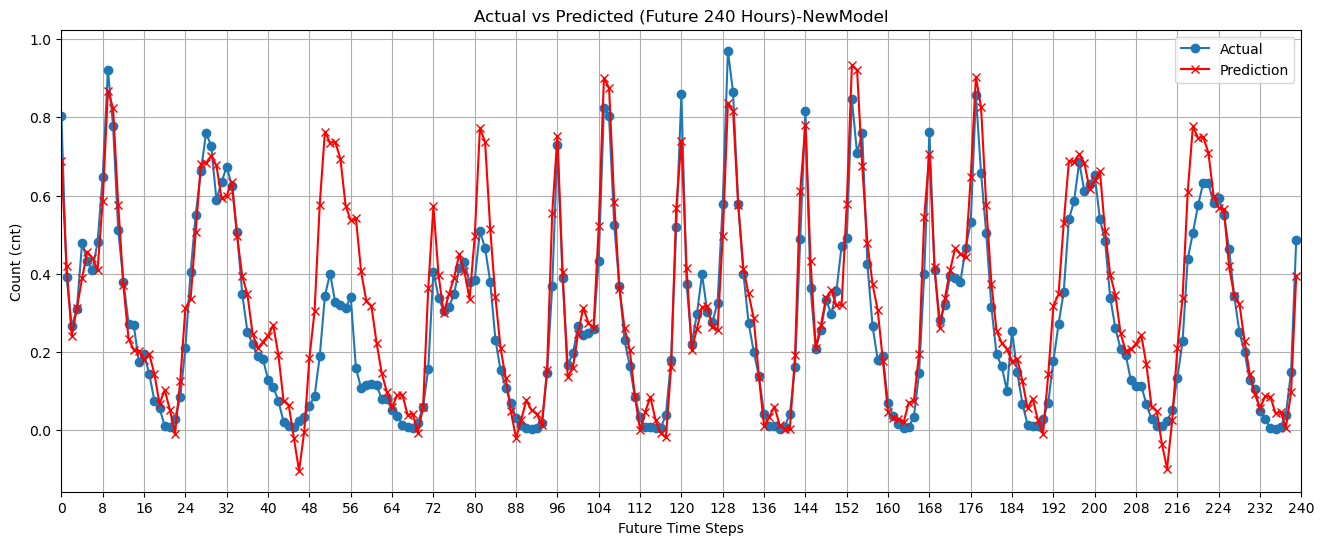

In [7]:
sample_idx = 0  # 选择一个样本进行可视化
plt.figure(figsize=(16, 6))
plt.plot(range(forecast_steps), y_true_inv[sample_idx], marker="o", label="Actual")
plt.plot(range(forecast_steps), y_pred_inv[sample_idx], marker="x", label="Prediction", color="r")
plt.legend()
plt.title("Actual vs Predicted (Future 240 Hours)-NewModel")
plt.xlabel("Future Time Steps")
plt.ylabel("Count (cnt)")
plt.grid()

x_major_locator=MultipleLocator(8)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlim(0,240)
plt.show()

In [8]:
expn = 5
mse_list, real_mse_list = [], []
mae_list, real_mae_list = [], []
for i in range(expn):
    model_path = "240-"+str(i+1)+".pth"
    model = torch.load(model_path)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    with torch.no_grad():
        # 使用模型进行预测
        mse, mae = 0, 0
        y_pred = model(X_test).cpu().numpy()  # 预测值转为 NumPy 数组
        y_true = y_test.cpu().numpy()  # 真实值转为 NumPy 数组
        y_true_inv = cnt_scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, forecast_steps))
        y_pred_inv = cnt_scaler.inverse_transform(y_pred.reshape(-1, forecast_steps))
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        real_mse = mean_squared_error(y_true_inv, y_pred_inv)
        real_mae = mean_absolute_error(y_true_inv, y_pred_inv)
        print(f"Test {i+1}: MSE = {mse:.4f}, MAE = {mae:.4f}, real_mse = {real_mse:.4f}, real_mae = {real_mae:.4f}")
        mse_list.append(mse)
        real_mse_list.append(real_mse)
        mae_list.append(mae)
        real_mae_list.append(real_mae)
average_mse = np.mean(mse_list)
average_mae = np.mean(mae_list)
real_average_mse = np.mean(real_mse_list)
real_average_mae = np.mean(real_mae_list)
mse_std = np.std(mse_list)
mae_std = np.std(mae_list)
real_mse_std = np.std(real_mse_list)
real_mae_std = np.std(real_mae_list)
print(f"Average MSE: {average_mse:.4f}")
print(f"Average MAE: {average_mae:.4f}")
print(f"Real Average MSE: {real_average_mse:.4f}")
print(f"Real Average MAE: {real_average_mae:.4f}")
print(f"MSE STD: {mse_std:.4f}")
print(f"MAE STD: {mae_std:.4f}")
print(f"Real MSE STD: {real_mse_std:.4f}")
print(f"Real MAE STD: {real_mae_std:.4f}")

Test 1: MSE = 0.0260, MAE = 0.1044, real_mse = 0.0260, real_mae = 0.1044
Test 2: MSE = 0.0262, MAE = 0.1075, real_mse = 0.0262, real_mae = 0.1075
Test 3: MSE = 0.0238, MAE = 0.1010, real_mse = 0.0238, real_mae = 0.1010
Test 4: MSE = 0.0238, MAE = 0.1011, real_mse = 0.0238, real_mae = 0.1011
Test 5: MSE = 0.0230, MAE = 0.0992, real_mse = 0.0230, real_mae = 0.0992
Average MSE: 0.0246
Average MAE: 0.1026
Real Average MSE: 0.0246
Real Average MAE: 0.1026
MSE STD: 0.0013
MAE STD: 0.0030
Real MSE STD: 0.0013
Real MAE STD: 0.0030
